In [53]:
!pip install datasets transformers

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [57]:
!pip install evaluate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Load MLQA Dataset

MLQA (MultiLingual Question Answering) is a benchmark dataset for evaluating cross-lingual question answering performance. MLQA consists of over 5K extractive QA instances (12K in English) in SQuAD format in seven languages - English, Arabic, German, Spanish, Hindi, Vietnamese and Simplified Chinese. MLQA is highly parallel, with QA instances parallel between 4 different languages on average.

In [58]:
from datasets import load_dataset
from evaluate import load as load_metric


langs = ["ar", "de", "vi", "zh", "en", "es", "hi"]
translate_langs = ["ar", "de", "vi", "zh", "es", "hi"]
langs_test = []
langs_translate_test = []

mlqa = {}

for lang1 in langs:
    for lang2 in langs:
        mlqa[f"{lang1}.{lang2}"] = load_dataset("mlqa", f"mlqa.{lang1}.{lang2}")
        langs_test.append(f"{lang1}.{lang2}")

for lang in translate_langs:
    mlqa[f"translate-train.{lang}"] = load_dataset("mlqa", f"mlqa-translate-train.{lang}")
    mlqa[f"translate-test.{lang}"] = load_dataset("mlqa", f"mlqa-translate-test.{lang}")
    langs_translate_test.append(f"translate-test.{lang}")

In [59]:
mlqa

{'ar.ar': DatasetDict({
     test: Dataset({
         features: ['context', 'question', 'answers', 'id'],
         num_rows: 5335
     })
     validation: Dataset({
         features: ['context', 'question', 'answers', 'id'],
         num_rows: 517
     })
 }),
 'ar.de': DatasetDict({
     test: Dataset({
         features: ['context', 'question', 'answers', 'id'],
         num_rows: 1649
     })
     validation: Dataset({
         features: ['context', 'question', 'answers', 'id'],
         num_rows: 207
     })
 }),
 'ar.vi': DatasetDict({
     test: Dataset({
         features: ['context', 'question', 'answers', 'id'],
         num_rows: 2047
     })
     validation: Dataset({
         features: ['context', 'question', 'answers', 'id'],
         num_rows: 163
     })
 }),
 'ar.zh': DatasetDict({
     test: Dataset({
         features: ['context', 'question', 'answers', 'id'],
         num_rows: 1912
     })
     validation: Dataset({
         features: ['context', 'question', 'answe

## Load SQuAD Dataset

In [60]:
squad = load_dataset("squad")

In [61]:
squad

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})

## Preprocessing SQuAD

Load the mBERT tokenizer to process the question and context fields.

In [62]:
from transformers import AutoTokenizer

model_name = "bert-base-multilingual-cased"

tokenizer = AutoTokenizer.from_pretrained(model_name)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In question answering tasks, handling long documents requires special care to ensure that important information, such as the answer, is not lost during input truncation. Instead of removing parts of the context, we split lengthy examples into multiple input features, each fitting within the model's maximum input length. To capture answers that might span across these split points, we introduce overlap between the features, controlled by the doc_stride parameter.

Key considerations for processing long contexts:

1. When truncating, apply truncation="only_second" to ensure that only the context (and not the question) is truncated, preserving question integrity.
2. Use return_offset_mapping=True to map answer positions back to their original context, making it possible to extract precise answer spans after tokenization.
3. Utilize sequence_ids to differentiate between tokens that belong to the question and those that belong to the context. This helps ensure accurate mapping of answers and context handling.

In [63]:
max_length = 360 # maximum length feature
doc_stride = 120 # authorized overlap.

In [64]:
def prepare_train_features(examples):
    # Remove leading whitespace from questions to prevent tokenization issues
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize examples with truncation and padding, handle long contexts with overlapping spans
    tokenized_examples = tokenizer(
        examples["question"],
        examples["context"],
        truncation="only_second",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Map tokenized features to their original examples
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    # Store token-to-character position mappings for later use
    offset_mapping = tokenized_examples.pop("offset_mapping")

    # Initialize start and end positions for answer labels
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        # Use CLS token index for impossible answers
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        # Identify context vs question parts in tokenized sequence
        sequence_ids = tokenized_examples.sequence_ids(i)
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]

        # If no answer, assign CLS token index
        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # Get start and end character positions of the answer
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            # Find token indices corresponding to the start and end of the answer
            token_start_index = 0
            while sequence_ids[token_start_index] != 1:
                token_start_index += 1

            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != 1:
                token_end_index -= 1

            # Check if the answer is within the current span, otherwise assign CLS token
            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                # Adjust token start and end indices to align with the answer span
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

In [65]:
squad_train = squad.map(prepare_train_features, batched=True, remove_columns=squad["train"].column_names)

Map:   0%|          | 0/10570 [00:00<?, ? examples/s]

The evaluation features share similarities with the training features, but they require additional considerations to ensure accurate processing. Specifically, we need to verify that a given span lies within the context (and not the question) and retrieve the corresponding text. To achieve this, we add two key components to our validation features:
1. Each feature must include the ID of its originating example, as one example can generate multiple features.
2. Use an offset mapping to relate token indices back to their character positions within the context, enabling precise span recovery.

To accommodate these requirements, we will re-process the validation set using a function similar to prepare_train_features with some modifications to handle these specific needs:

In [66]:
def prepare_validation_features(examples):
    # Remove leading whitespace from questions
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize with truncation and padding, keeping overlapping spans for long contexts
    tokenized_examples = tokenizer(
        examples["question"],
        examples["context"],
        truncation="only_second",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Map features to original examples
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    # Add example_id and filter context offsets
    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token
        # position is part of the context or not.
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

Use the map function again to apply the preprocessing function over the validation dataset. You can speed up the map function by setting `batched=True` to process multiple elements of the dataset at once. Remove the columns you don’t need.

In [67]:
squad_eval = squad["validation"].map(prepare_validation_features, batched=True, remove_columns=squad["validation"].column_names)

## Fine-tuning mBERT

With our data prepared for training, we can proceed to download and fine-tune a pretrained model. For our question-answering task, we use the AutoModelForQuestionAnswering class. Similar to the tokenizer, the from_pretrained method automatically downloads and caches the model, making it ready for customization and training:

In [68]:
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer

model_name = "bert-base-multilingual-cased"
model = AutoModelForQuestionAnswering.from_pretrained(model_name)

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [69]:
# A data collator is used to batch our processed examples during training.
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

To obtain predictions for all features, we use the Trainer.predict method. Before instantiating a Trainer, we need to define three key components, with the most critical being TrainingArguments.

In [70]:
batch_size = 16
args = TrainingArguments(
    "bert-base-multilingual-cased-squad",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Next, we will evaluate the model and compute metrics (note that evaluation can be time-consuming, so during training, we will only compute the evaluation loss).

Finally, we pass our datasets and configuration to the Trainer for training:

In [71]:
trainer = Trainer(
    model,
    args,
    train_dataset=squad_train["train"],
    eval_dataset=squad_train["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

With everything set up, we can fine-tune the model simply by calling the train method:

In [72]:
trainer.train()

In [73]:
# save the model
trainer.save_model("bert-base-multilingual-cased-squad-finetuned")

## Evaluating mBERT

In [89]:
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer

model_name = "bert-base-multilingual-cased-squad-finetuned"
# "bert-base-multilingual-cased-squad-finetuned"
model = AutoModelForQuestionAnswering.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DefaultDataCollator()

batch_size = 16
training_args = TrainingArguments(
    output_dir="bert-base-multilingual-cased-finetuned-squad",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=None,
    eval_dataset=None,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [90]:
raw_predictions = trainer.predict(squad_eval)

In [91]:
# Make the columns that the Trainer automatically hides visible.

squad_eval.set_format(type=squad_eval.format["type"], columns=list(squad_eval.features.keys()))

To refine our previous test, we use None values in offset mappings to easily verify if an answer lies entirely within the context. We also filter out overly long answers using a tunable hyperparameter.

Since each example can produce multiple features, we create a mapping from examples to their feature indices, consolidate all answers across features for a given example, and select the best one.

In [92]:
from tqdm.auto import tqdm
import collections
import numpy as np

def postprocess_qa_predictions(examples, features, raw_predictions, n_best_size = 20, max_answer_length = 30):
    all_start_logits, all_end_logits = raw_predictions
    # Build a map example to its corresponding features.
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    # The dictionaries we have to fill.
    predictions = collections.OrderedDict()

    # Logging.
    print(f"Post-processing {len(examples)} example predictions split into {len(features)} features.")

    # Let's loop over all the examples!
    for example_index, example in enumerate(tqdm(examples)):
        # Those are the indices of the features associated to the current example.
        feature_indices = features_per_example[example_index]

        valid_answers = []

        context = example["context"]
        # Looping through all the features associated to the current example.
        for feature_index in feature_indices:
            # We grab the predictions of the model for this feature.
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            # This is what will allow us to map some the positions in our logits to span of texts in the original
            # context.
            offset_mapping = features[feature_index]["offset_mapping"]

            # Go through all possibilities for the `n_best_size` greater start and end logits.
            start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
                    # to part of the input_ids that are not in the context.
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index] is None
                    ):
                        continue
                    # Don't consider answers with a length that is either < 0 or > max_answer_length.
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue

                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    valid_answers.append(
                        {
                            "score": start_logits[start_index] + end_logits[end_index],
                            "text": context[start_char: end_char]
                        }
                    )

        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
        else:
            # In the very rare edge case we have not a single non-null prediction, we create a fake prediction to avoid
            # failure.
            best_answer = {"text": "", "score": 0.0}

        # Let's pick our final answer: the best one
        predictions[example["id"]] = best_answer["text"]

    return predictions

In [93]:
final_predictions = postprocess_qa_predictions(squad["validation"], squad_eval, raw_predictions.predictions)

Post-processing 10570 example predictions split into 10914 features.


  0%|          | 0/10570 [00:00<?, ?it/s]

In [94]:
# Load the metric and call compute to evaluate it.
metric = load_metric("squad")


In [95]:

formatted_predictions = [{"id": k, "prediction_text": v} for k, v in final_predictions.items()]
references = [{"id": ex["id"], "answers": ex["answers"]} for ex in squad["validation"]]
metric.compute(predictions=formatted_predictions, references=references)

{'exact_match': 81.91106906338695, 'f1': 89.11117220672692}

## Zero-Shot mBERT

Zero-Shot performance of the mBERT model fine-tuned on SQuAD.

In [96]:
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, TrainingArguments, Trainer, DefaultDataCollator

model_name = "bert-base-multilingual-cased-squad-finetuned"
model = AutoModelForQuestionAnswering.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DefaultDataCollator()

batch_size = 16
training_args = TrainingArguments(
    output_dir="bert-base-multilingual-cased-finetuned-squad",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=None,
    eval_dataset=None,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Use the map function to apply the preprocessing function over the validation dataset. To speed up processing, set batched=True to handle multiple elements simultaneously. Remove any unnecessary columns during this step.

In [97]:
from collections import defaultdict

mlqa_prep = defaultdict(dict)

def map_datasets(langs, split, prepare_features):
    for lang in langs:
        mlqa_prep[lang][split] = mlqa[lang][split].map(prepare_features, batched=True, remove_columns=mlqa[lang][split].column_names)

In [32]:
split = "test"
map_datasets(langs_test, split, prepare_validation_features)

Map:   0%|          | 0/5335 [00:00<?, ? examples/s]

Map:   0%|          | 0/1649 [00:00<?, ? examples/s]

Map:   0%|          | 0/2047 [00:00<?, ? examples/s]

Map:   0%|          | 0/1912 [00:00<?, ? examples/s]

Map:   0%|          | 0/5335 [00:00<?, ? examples/s]

Map:   0%|          | 0/1978 [00:00<?, ? examples/s]

Map:   0%|          | 0/1831 [00:00<?, ? examples/s]

Map:   0%|          | 0/1649 [00:00<?, ? examples/s]

Map:   0%|          | 0/4517 [00:00<?, ? examples/s]

Map:   0%|          | 0/1675 [00:00<?, ? examples/s]

Map:   0%|          | 0/1621 [00:00<?, ? examples/s]

Map:   0%|          | 0/4517 [00:00<?, ? examples/s]

Map:   0%|          | 0/1776 [00:00<?, ? examples/s]

Map:   0%|          | 0/1430 [00:00<?, ? examples/s]

Map:   0%|          | 0/2047 [00:00<?, ? examples/s]

Map:   0%|          | 0/1675 [00:00<?, ? examples/s]

Map:   0%|          | 0/5495 [00:00<?, ? examples/s]

Map:   0%|          | 0/1943 [00:00<?, ? examples/s]

Map:   0%|          | 0/5495 [00:00<?, ? examples/s]

Map:   0%|          | 0/2018 [00:00<?, ? examples/s]

Map:   0%|          | 0/1947 [00:00<?, ? examples/s]

Map:   0%|          | 0/1912 [00:00<?, ? examples/s]

Map:   0%|          | 0/1621 [00:00<?, ? examples/s]

Map:   0%|          | 0/1943 [00:00<?, ? examples/s]

Map:   0%|          | 0/5137 [00:00<?, ? examples/s]

Map:   0%|          | 0/5137 [00:00<?, ? examples/s]

Map:   0%|          | 0/1947 [00:00<?, ? examples/s]

Map:   0%|          | 0/1767 [00:00<?, ? examples/s]

Map:   0%|          | 0/5335 [00:00<?, ? examples/s]

Map:   0%|          | 0/4517 [00:00<?, ? examples/s]

Map:   0%|          | 0/5495 [00:00<?, ? examples/s]

Map:   0%|          | 0/5137 [00:00<?, ? examples/s]

Map:   0%|          | 0/11590 [00:00<?, ? examples/s]

Map:   0%|          | 0/5253 [00:00<?, ? examples/s]

Map:   0%|          | 0/4918 [00:00<?, ? examples/s]

Map:   0%|          | 0/1978 [00:00<?, ? examples/s]

Map:   0%|          | 0/1776 [00:00<?, ? examples/s]

Map:   0%|          | 0/2018 [00:00<?, ? examples/s]

Map:   0%|          | 0/1947 [00:00<?, ? examples/s]

Map:   0%|          | 0/5253 [00:00<?, ? examples/s]

Map:   0%|          | 0/5253 [00:00<?, ? examples/s]

Map:   0%|          | 0/1723 [00:00<?, ? examples/s]

Map:   0%|          | 0/1831 [00:00<?, ? examples/s]

Map:   0%|          | 0/1430 [00:00<?, ? examples/s]

Map:   0%|          | 0/1947 [00:00<?, ? examples/s]

Map:   0%|          | 0/1767 [00:00<?, ? examples/s]

Map:   0%|          | 0/4918 [00:00<?, ? examples/s]

Map:   0%|          | 0/1723 [00:00<?, ? examples/s]

Map:   0%|          | 0/4918 [00:00<?, ? examples/s]

In [98]:
def compute_results(langs, split):
    results = {}
    for lang in langs:
        # We can grab the predictions for all features by using the method
        raw_predictions = trainer.predict(mlqa_prep[lang][split])

        # example_id and offset_mapping which we will need for our post-processing
        mlqa_prep[lang][split].set_format(type=mlqa_prep[lang][split].format["type"],
                        columns=list(mlqa_prep[lang][split].features.keys()))

        # And we can apply our post-processing function to our raw predictions
        final_predictions = postprocess_qa_predictions(mlqa[lang][split], mlqa_prep[lang][split], raw_predictions.predictions)

        # We just need to format predictions and labels a bit as it expects a list of dictionaries and not one big dictionary.
        formatted_predictions = [{"id": k, "prediction_text": v} for k, v in final_predictions.items()]
        references = [{"id": ex["id"], "answers": ex["answers"]} for ex in mlqa[lang][split]]
        results[lang] = metric.compute(predictions=formatted_predictions, references=references)
    return results

In [34]:
results_zero_shot_mbert = compute_results(langs_test, split)
print(results_zero_shot_mbert)

Post-processing 5335 example predictions split into 7891 features.


  0%|          | 0/5335 [00:00<?, ?it/s]

Post-processing 1649 example predictions split into 2161 features.


  0%|          | 0/1649 [00:00<?, ?it/s]

Post-processing 2047 example predictions split into 3059 features.


  0%|          | 0/2047 [00:00<?, ?it/s]

Post-processing 1912 example predictions split into 3038 features.


  0%|          | 0/1912 [00:00<?, ?it/s]

Post-processing 5335 example predictions split into 7790 features.


  0%|          | 0/5335 [00:00<?, ?it/s]

Post-processing 1978 example predictions split into 2879 features.


  0%|          | 0/1978 [00:00<?, ?it/s]

Post-processing 1831 example predictions split into 2774 features.


  0%|          | 0/1831 [00:00<?, ?it/s]

Post-processing 1649 example predictions split into 1954 features.


  0%|          | 0/1649 [00:00<?, ?it/s]

Post-processing 4517 example predictions split into 5344 features.


  0%|          | 0/4517 [00:00<?, ?it/s]

Post-processing 1675 example predictions split into 2034 features.


  0%|          | 0/1675 [00:00<?, ?it/s]

Post-processing 1621 example predictions split into 2006 features.


  0%|          | 0/1621 [00:00<?, ?it/s]

Post-processing 4517 example predictions split into 5331 features.


  0%|          | 0/4517 [00:00<?, ?it/s]

Post-processing 1776 example predictions split into 2085 features.


  0%|          | 0/1776 [00:00<?, ?it/s]

Post-processing 1430 example predictions split into 1637 features.


  0%|          | 0/1430 [00:00<?, ?it/s]

Post-processing 2047 example predictions split into 3032 features.


  0%|          | 0/2047 [00:00<?, ?it/s]

Post-processing 1675 example predictions split into 2256 features.


  0%|          | 0/1675 [00:00<?, ?it/s]

Post-processing 5495 example predictions split into 7690 features.


  0%|          | 0/5495 [00:00<?, ?it/s]

Post-processing 1943 example predictions split into 2845 features.


  0%|          | 0/1943 [00:00<?, ?it/s]

Post-processing 5495 example predictions split into 7630 features.


  0%|          | 0/5495 [00:00<?, ?it/s]

Post-processing 2018 example predictions split into 2779 features.


  0%|          | 0/2018 [00:00<?, ?it/s]

Post-processing 1947 example predictions split into 2621 features.


  0%|          | 0/1947 [00:00<?, ?it/s]

Post-processing 1912 example predictions split into 2458 features.


  0%|          | 0/1912 [00:00<?, ?it/s]

Post-processing 1621 example predictions split into 2068 features.


  0%|          | 0/1621 [00:00<?, ?it/s]

Post-processing 1943 example predictions split into 2569 features.


  0%|          | 0/1943 [00:00<?, ?it/s]

Post-processing 5137 example predictions split into 6551 features.


  0%|          | 0/5137 [00:00<?, ?it/s]

Post-processing 5137 example predictions split into 6508 features.


  0%|          | 0/5137 [00:00<?, ?it/s]

Post-processing 1947 example predictions split into 2531 features.


  0%|          | 0/1947 [00:00<?, ?it/s]

Post-processing 1767 example predictions split into 2145 features.


  0%|          | 0/1767 [00:00<?, ?it/s]

Post-processing 5335 example predictions split into 7159 features.


  0%|          | 0/5335 [00:00<?, ?it/s]

Post-processing 4517 example predictions split into 5747 features.


  0%|          | 0/4517 [00:00<?, ?it/s]

Post-processing 5495 example predictions split into 7450 features.


  0%|          | 0/5495 [00:00<?, ?it/s]

Post-processing 5137 example predictions split into 7022 features.


  0%|          | 0/5137 [00:00<?, ?it/s]

Post-processing 11590 example predictions split into 15256 features.


  0%|          | 0/11590 [00:00<?, ?it/s]

Post-processing 5253 example predictions split into 6819 features.


  0%|          | 0/5253 [00:00<?, ?it/s]

Post-processing 4918 example predictions split into 6624 features.


  0%|          | 0/4918 [00:00<?, ?it/s]

Post-processing 1978 example predictions split into 2093 features.


  0%|          | 0/1978 [00:00<?, ?it/s]

Post-processing 1776 example predictions split into 1851 features.


  0%|          | 0/1776 [00:00<?, ?it/s]

Post-processing 2018 example predictions split into 2130 features.


  0%|          | 0/2018 [00:00<?, ?it/s]

Post-processing 1947 example predictions split into 2057 features.


  0%|          | 0/1947 [00:00<?, ?it/s]

Post-processing 5253 example predictions split into 5516 features.


  0%|          | 0/5253 [00:00<?, ?it/s]

Post-processing 5253 example predictions split into 5526 features.


  0%|          | 0/5253 [00:00<?, ?it/s]

Post-processing 1723 example predictions split into 1812 features.


  0%|          | 0/1723 [00:00<?, ?it/s]

Post-processing 1831 example predictions split into 2953 features.


  0%|          | 0/1831 [00:00<?, ?it/s]

Post-processing 1430 example predictions split into 2085 features.


  0%|          | 0/1430 [00:00<?, ?it/s]

Post-processing 1947 example predictions split into 3214 features.


  0%|          | 0/1947 [00:00<?, ?it/s]

Post-processing 1767 example predictions split into 2921 features.


  0%|          | 0/1767 [00:00<?, ?it/s]

Post-processing 4918 example predictions split into 7694 features.


  0%|          | 0/4918 [00:00<?, ?it/s]

Post-processing 1723 example predictions split into 2598 features.


  0%|          | 0/1723 [00:00<?, ?it/s]

Post-processing 4918 example predictions split into 7866 features.


  0%|          | 0/4918 [00:00<?, ?it/s]

{'ar.ar': {'exact_match': 28.209934395501406, 'f1': 45.11423890431906}, 'ar.de': {'exact_match': 30.442692540933898, 'f1': 46.111526906634786}, 'ar.vi': {'exact_match': 19.88275525158769, 'f1': 35.71258882998514}, 'ar.zh': {'exact_match': 21.39121338912134, 'f1': 36.64929593991528}, 'ar.en': {'exact_match': 33.53327085285848, 'f1': 50.97053283299842}, 'ar.es': {'exact_match': 28.412537917087967, 'f1': 45.15225060880987}, 'ar.hi': {'exact_match': 17.531403604587656, 'f1': 30.53140982748336}, 'de.ar': {'exact_match': 23.83262583383869, 'f1': 36.8095980703044}, 'de.de': {'exact_match': 43.56874031436794, 'f1': 59.255068207399816}, 'de.vi': {'exact_match': 29.91044776119403, 'f1': 43.932381508729975}, 'de.zh': {'exact_match': 30.598396051819865, 'f1': 46.49052796186293}, 'de.en': {'exact_match': 46.75669692273633, 'f1': 62.40690001613036}, 'de.es': {'exact_match': 41.1036036036036, 'f1': 56.506402574851634}, 'de.hi': {'exact_match': 21.748251748251747, 'f1': 34.32597749236271}, 'vi.ar': {'

In [121]:
import pandas as pd

def results_df(results_dict, model):
    F1colname = "F1_" + model
    EMcolname = "EM_" + model
    dict_results = defaultdict(list)
    for lang, scores in results_dict.items():
        dict_results["lang"].append(lang)
        dict_results[F1colname].append(scores['f1'])
        dict_results[EMcolname].append(scores['exact_match'])

    avg_f1 = np.average(dict_results[F1colname])
    avg_em = np.average(dict_results[EMcolname])
    dict_results["lang"].append('avg')
    dict_results[F1colname].append(avg_f1)
    dict_results[EMcolname].append(avg_em)
    df_results = pd.DataFrame(dict_results).round(2)
    return df_results

In [100]:
import os

os.makedirs("results/mlqa", exist_ok=True)

In [ ]:
df_results_zero_shot_mbert = results_df(results_zero_shot_mbert, "Zero-shot mBERT")
df_results_zero_shot_mbert.to_csv("results/mlqa/results_zero_shot_mbert.csv")
df_results_zero_shot_mbert

## Translate Test with mBERT 

In [101]:
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, TrainingArguments, Trainer, DefaultDataCollator

model_name = "bert-base-multilingual-cased-squad-finetuned"
model = AutoModelForQuestionAnswering.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DefaultDataCollator()

batch_size = 16
training_args = TrainingArguments(
    output_dir="bert-base-multilingual-cased-finetuned-squad",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=None,
    eval_dataset=None,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [42]:
split = "test"
map_datasets(langs_translate_test, split, prepare_validation_features)

Map:   0%|          | 0/5335 [00:00<?, ? examples/s]

Map:   0%|          | 0/4517 [00:00<?, ? examples/s]

Map:   0%|          | 0/5495 [00:00<?, ? examples/s]

Map:   0%|          | 0/5137 [00:00<?, ? examples/s]

Map:   0%|          | 0/5253 [00:00<?, ? examples/s]

Map:   0%|          | 0/4918 [00:00<?, ? examples/s]

In [43]:
results_translate_test_mbert = compute_results(langs_translate_test, split)
print(results_translate_test_mbert)

Post-processing 5335 example predictions split into 6403 features.


  0%|          | 0/5335 [00:00<?, ?it/s]

Post-processing 4517 example predictions split into 5116 features.


  0%|          | 0/4517 [00:00<?, ?it/s]

Post-processing 5495 example predictions split into 6855 features.


  0%|          | 0/5495 [00:00<?, ?it/s]

Post-processing 5137 example predictions split into 5816 features.


  0%|          | 0/5137 [00:00<?, ?it/s]

Post-processing 5253 example predictions split into 5410 features.


  0%|          | 0/5253 [00:00<?, ?it/s]

Post-processing 4918 example predictions split into 5692 features.


  0%|          | 0/4918 [00:00<?, ?it/s]

{'translate-test.ar': {'exact_match': 27.291471415182755, 'f1': 49.59916278115005}, 'translate-test.de': {'exact_match': 34.89041399158734, 'f1': 53.63686495832419}, 'translate-test.vi': {'exact_match': 32.02911737943585, 'f1': 53.40747214904142}, 'translate-test.zh': {'exact_match': 24.644734280708583, 'f1': 46.042213443851196}, 'translate-test.es': {'exact_match': 43.042071197411005, 'f1': 64.25882918822066}, 'translate-test.hi': {'exact_match': 31.110207401382677, 'f1': 51.89755968071926}}


In [44]:
df_results_translate_test_mbert = results_df(results_translate_test_mbert, "Translate-test mBERT")
df_results_translate_test_mbert.to_csv("results/mlqa/results_translate_test_mbert.csv")
df_results_translate_test_mbert

,lang,F1_Translate-test mBERT,EM_Translate-test mBERT
0,translate-test.ar,49.60,27.29
1,translate-test.de,53.64,34.89
2,translate-test.vi,53.41,32.03
3,translate-test.zh,46.04,24.64
4,translate-test.es,64.26,43.04
5,translate-test.hi,51.90,31.11
6,avg,53.14,32.17


## CoT mBERT 

Performance evaluation of the mBERT model fine-tuned on SQuAD, incorporating Chain of Thought (CoT) prompt engineering. 
The CoT methodology aims to guide the model in systematically breaking down tasks, enhancing comprehension, and improving answer accuracy. This experiment demonstrates the impact of step-by-step reasoning prompts on multilingual question-answering tasks.

In [102]:
def prepare_validation_features_with_CoT(examples):
    cot_prompt = "Let's think step-by-step to answer this question: "
    # Add CoT to questions + (Remove leading whitespace from questions)
    examples["question"] = [cot_prompt + q.lstrip() for q in examples["question"]]

    # Tokenize with truncation and padding, keeping overlapping spans for long contexts
    tokenized_examples = tokenizer(
        examples["question"],
        examples["context"],
        truncation="only_second",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Map features to original examples
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    # Add example_id and filter context offsets
    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token
        # position is part of the context or not.
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
            if o is not None  # Ensure valid offsets
        ]

    return tokenized_examples


In [103]:
split = "test"
map_datasets(langs_test, split, prepare_validation_features_with_CoT)

Map:   0%|          | 0/5335 [00:00<?, ? examples/s]

In [104]:
results_CoT_mbert = compute_results(langs_test, split)
print(results_CoT_mbert)

Post-processing 5335 example predictions split into 8128 features.


  0%|          | 0/5335 [00:00<?, ?it/s]

Post-processing 1649 example predictions split into 2219 features.


  0%|          | 0/1649 [00:00<?, ?it/s]

Post-processing 2047 example predictions split into 3154 features.


  0%|          | 0/2047 [00:00<?, ?it/s]

Post-processing 1912 example predictions split into 3151 features.


  0%|          | 0/1912 [00:00<?, ?it/s]

Post-processing 5335 example predictions split into 8042 features.


  0%|          | 0/5335 [00:00<?, ?it/s]

Post-processing 1978 example predictions split into 2961 features.


  0%|          | 0/1978 [00:00<?, ?it/s]

Post-processing 1831 example predictions split into 2877 features.


  0%|          | 0/1831 [00:00<?, ?it/s]

Post-processing 1649 example predictions split into 1979 features.


  0%|          | 0/1649 [00:00<?, ?it/s]

Post-processing 4517 example predictions split into 5425 features.


  0%|          | 0/4517 [00:00<?, ?it/s]

Post-processing 1675 example predictions split into 2061 features.


  0%|          | 0/1675 [00:00<?, ?it/s]

Post-processing 1621 example predictions split into 2049 features.


  0%|          | 0/1621 [00:00<?, ?it/s]

Post-processing 4517 example predictions split into 5410 features.


  0%|          | 0/4517 [00:00<?, ?it/s]

Post-processing 1776 example predictions split into 2120 features.


  0%|          | 0/1776 [00:00<?, ?it/s]

Post-processing 1430 example predictions split into 1659 features.


  0%|          | 0/1430 [00:00<?, ?it/s]

Post-processing 2047 example predictions split into 3113 features.


  0%|          | 0/2047 [00:00<?, ?it/s]

Post-processing 1675 example predictions split into 2307 features.


  0%|          | 0/1675 [00:00<?, ?it/s]

Post-processing 5495 example predictions split into 7911 features.


  0%|          | 0/5495 [00:00<?, ?it/s]

Post-processing 1943 example predictions split into 2944 features.


  0%|          | 0/1943 [00:00<?, ?it/s]

Post-processing 5495 example predictions split into 7855 features.


  0%|          | 0/5495 [00:00<?, ?it/s]

Post-processing 2018 example predictions split into 2865 features.


  0%|          | 0/2018 [00:00<?, ?it/s]

Post-processing 1947 example predictions split into 2689 features.


  0%|          | 0/1947 [00:00<?, ?it/s]

Post-processing 1912 example predictions split into 2518 features.


  0%|          | 0/1912 [00:00<?, ?it/s]

Post-processing 1621 example predictions split into 2120 features.


  0%|          | 0/1621 [00:00<?, ?it/s]

Post-processing 1943 example predictions split into 2636 features.


  0%|          | 0/1943 [00:00<?, ?it/s]

Post-processing 5137 example predictions split into 6703 features.


  0%|          | 0/5137 [00:00<?, ?it/s]

Post-processing 5137 example predictions split into 6661 features.


  0%|          | 0/5137 [00:00<?, ?it/s]

Post-processing 1947 example predictions split into 2590 features.


  0%|          | 0/1947 [00:00<?, ?it/s]

Post-processing 1767 example predictions split into 2197 features.


  0%|          | 0/1767 [00:00<?, ?it/s]

Post-processing 5335 example predictions split into 7346 features.


  0%|          | 0/5335 [00:00<?, ?it/s]

Post-processing 4517 example predictions split into 5885 features.


  0%|          | 0/4517 [00:00<?, ?it/s]

Post-processing 5495 example predictions split into 7664 features.


  0%|          | 0/5495 [00:00<?, ?it/s]

Post-processing 5137 example predictions split into 7208 features.


  0%|          | 0/5137 [00:00<?, ?it/s]

Post-processing 11590 example predictions split into 15647 features.


  0%|          | 0/11590 [00:00<?, ?it/s]

Post-processing 5253 example predictions split into 6983 features.


  0%|          | 0/5253 [00:00<?, ?it/s]

Post-processing 4918 example predictions split into 6772 features.


  0%|          | 0/4918 [00:00<?, ?it/s]

Post-processing 1978 example predictions split into 2122 features.


  0%|          | 0/1978 [00:00<?, ?it/s]

Post-processing 1776 example predictions split into 1870 features.


  0%|          | 0/1776 [00:00<?, ?it/s]

Post-processing 2018 example predictions split into 2154 features.


  0%|          | 0/2018 [00:00<?, ?it/s]

Post-processing 1947 example predictions split into 2092 features.


  0%|          | 0/1947 [00:00<?, ?it/s]

Post-processing 5253 example predictions split into 5580 features.


  0%|          | 0/5253 [00:00<?, ?it/s]

Post-processing 5253 example predictions split into 5592 features.


  0%|          | 0/5253 [00:00<?, ?it/s]

Post-processing 1723 example predictions split into 1831 features.


  0%|          | 0/1723 [00:00<?, ?it/s]

Post-processing 1831 example predictions split into 3089 features.


  0%|          | 0/1831 [00:00<?, ?it/s]

Post-processing 1430 example predictions split into 2161 features.


  0%|          | 0/1430 [00:00<?, ?it/s]

Post-processing 1947 example predictions split into 3351 features.


  0%|          | 0/1947 [00:00<?, ?it/s]

Post-processing 1767 example predictions split into 3052 features.


  0%|          | 0/1767 [00:00<?, ?it/s]

Post-processing 4918 example predictions split into 7991 features.


  0%|          | 0/4918 [00:00<?, ?it/s]

Post-processing 1723 example predictions split into 2702 features.


  0%|          | 0/1723 [00:00<?, ?it/s]

Post-processing 4918 example predictions split into 8209 features.


  0%|          | 0/4918 [00:00<?, ?it/s]

{'ar.ar': {'exact_match': 18.87535145267104, 'f1': 33.510753751511906}, 'ar.de': {'exact_match': 19.466343238326257, 'f1': 33.16717500301403}, 'ar.vi': {'exact_match': 10.258915486077186, 'f1': 21.66359018241248}, 'ar.zh': {'exact_match': 12.604602510460252, 'f1': 24.624978000503255}, 'ar.en': {'exact_match': 29.840674789128396, 'f1': 45.971610678437976}, 'ar.es': {'exact_match': 18.452982810920123, 'f1': 31.69937555590928}, 'ar.hi': {'exact_match': 9.77607864554888, 'f1': 19.95944786269585}, 'de.ar': {'exact_match': 11.764705882352942, 'f1': 20.61217215476433}, 'de.de': {'exact_match': 35.68740314367943, 'f1': 51.35670877906494}, 'de.vi': {'exact_match': 16.53731343283582, 'f1': 28.133920951068255}, 'de.zh': {'exact_match': 19.86428130783467, 'f1': 32.5765346238081}, 'de.en': {'exact_match': 43.34735443878681, 'f1': 58.53676072948074}, 'de.es': {'exact_match': 28.153153153153152, 'f1': 41.79286935487674}, 'de.hi': {'exact_match': 12.867132867132867, 'f1': 22.856497537704055}, 'vi.ar':

In [112]:
print(results_CoT_mbert)

{'ar.ar': {'exact_match': 18.87535145267104, 'f1': 33.510753751511906}, 'ar.de': {'exact_match': 19.466343238326257, 'f1': 33.16717500301403}, 'ar.vi': {'exact_match': 10.258915486077186, 'f1': 21.66359018241248}, 'ar.zh': {'exact_match': 12.604602510460252, 'f1': 24.624978000503255}, 'ar.en': {'exact_match': 29.840674789128396, 'f1': 45.971610678437976}, 'ar.es': {'exact_match': 18.452982810920123, 'f1': 31.69937555590928}, 'ar.hi': {'exact_match': 9.77607864554888, 'f1': 19.95944786269585}, 'de.ar': {'exact_match': 11.764705882352942, 'f1': 20.61217215476433}, 'de.de': {'exact_match': 35.68740314367943, 'f1': 51.35670877906494}, 'de.vi': {'exact_match': 16.53731343283582, 'f1': 28.133920951068255}, 'de.zh': {'exact_match': 19.86428130783467, 'f1': 32.5765346238081}, 'de.en': {'exact_match': 43.34735443878681, 'f1': 58.53676072948074}, 'de.es': {'exact_match': 28.153153153153152, 'f1': 41.79286935487674}, 'de.hi': {'exact_match': 12.867132867132867, 'f1': 22.856497537704055}, 'vi.ar':

In [124]:

df_results_CoT_mbert = results_df(results_CoT_mbert, "CoT-test mBERT")
df_results_CoT_mbert.to_csv("results/mlqa/results_CoT_test_mbert.csv")
df_results_CoT_mbert

,lang,F1_CoT-test mBERT,EM_CoT-test mBERT
0,ar.ar,33.51,18.88
1,ar.de,33.17,19.47
2,ar.vi,21.66,10.26
3,ar.zh,24.62,12.60
4,ar.en,45.97,29.84
5,ar.es,31.70,18.45
6,ar.hi,19.96,9.78
7,de.ar,20.61,11.76
8,de.de,51.36,35.69
9,de.vi,28.13,16.54


# Results- MLQA

In [125]:
import pandas as pd

df_results_zero_shot_mbert = pd.read_csv('results/mlqa/results_zero_shot_mbert.csv')
df_results_translate_test_mbert = pd.read_csv("results/mlqa/results_translate_test_mbert.csv")
df_results_CoT_test_mbert = pd.read_csv("results/mlqa/results_CoT_test_mbert.csv")

dataframes = [df_results_zero_shot_mbert,
              df_results_translate_test_mbert,
              df_results_CoT_test_mbert,
              ]

## Translate train and test


In [126]:
# Translate train and test
dfs = []
for df in dataframes:
    name1 = list(df.columns)[2]
    name2 = list(df.columns)[3]
    name = name1[3:]
    df = df.round(1)
    df = df.astype({name1: 'str', name2: 'str'}) #float to string
    df[name] = df[[name1, name2]].apply(lambda x: ' / '.join(x), axis=1) #concat F1 and EM
    df = df.drop([name1, name2,"Unnamed: 0"], axis=1) #remove useless columns
    df = df.set_index('lang').T #rotate dataframe
    dfs.append(df)

In [127]:
results_df = pd.concat(dfs, axis=0)
# reorder languages to match baseline
results_df = results_df[['en.en', 'es.es', 'de.de', 'ar.ar', 'hi.hi', 'vi.vi', 'zh.zh', 'translate-test.es', 'translate-test.de', 'translate-test.ar', 'translate-test.hi', 'translate-test.vi', 'translate-test.zh', 'avg']]
#reorganize columns
results_df['es.es'] = results_df['es.es'].combine_first(results_df['translate-test.es'])
results_df['de.de'] = results_df['de.de'].combine_first(results_df['translate-test.de'])
results_df['ar.ar'] = results_df['ar.ar'].combine_first(results_df['translate-test.ar'])
results_df['hi.hi'] = results_df['hi.hi'].combine_first(results_df['translate-test.hi'])
results_df['vi.vi'] = results_df['vi.vi'].combine_first(results_df['translate-test.vi'])
results_df['zh.zh'] = results_df['zh.zh'].combine_first(results_df['translate-test.zh'])
results_df = results_df.drop(columns = ['translate-test.es', 'translate-test.de', 'translate-test.ar', 'translate-test.hi', 'translate-test.vi', 'translate-test.zh'])
results_df.rename(columns={'en.en': 'en', 'es.es': 'es', 'de.de': 'de', 'ar.ar': 'ar', 'hi.hi': 'hi', 'vi.vi': 'vi', 'zh.zh': 'zh'}, inplace=True)

#recalculating zero shot averages:

for ind, row in results_df.iterrows():
    F1 = []
    EM = []
    for i in range(0, 7):
        if type(row[i]) is float:
            continue
        F1.append(float(row[i].split('/')[0]))
        EM.append(float(row[i].split('/')[1]))
    avgF1 = round(np.average(F1), 1)
    avgEM = round(np.average(EM), 1)
    results_df.loc[ind, 'avg'] = str(avgF1) + ' / ' + str(avgEM)

# renaming the rows
rows = ["Zero-shot mBERT",
        "Translate-test mBERT",
        "CoT-test BERT"]
results_df = results_df.rename(dict(zip(results_df.index, rows)))
results_df.to_csv("results/mlqa/results.csv")
display(results_df)

/tmp/ipykernel_31/1202025704.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if type(row[i]) is float:
/tmp/ipykernel_31/1202025704.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  F1.append(float(row[i].split('/')[0]))
/tmp/ipykernel_31/1202025704.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  EM.append(float(row[i].split('/')[1]))
/tmp/ipykernel_31/1202025704.py:20: FutureWarning: Series.__getitem__ treating keys as

lang,en,es,de,ar,hi,vi,zh,avg
Zero-shot mBERT,80.1 / 66.9,64.9 / 43.6,59.3 / 43.6,45.1 / 28.2,46.3 / 30.0,58.6 / 39.4,37.3 / 36.7,55.9 / 41.2
Translate-test mBERT,NaN,64.3 / 43.0,53.6 / 34.9,49.6 / 27.3,51.9 / 31.1,53.4 / 32.0,46.0 / 24.6,53.1 / 32.2
CoT-test BERT,76.3 / 62.5,55.0 / 34.9,51.4 / 35.7,33.5 / 18.9,34.0 / 18.5,43.9 / 25.8,27.1 / 26.5,45.9 / 31.8


In [128]:
results_df.to_markdown()

'|                      | en          | es          | de          | ar          | hi          | vi          | zh          | avg         |\n|:---------------------|:------------|:------------|:------------|:------------|:------------|:------------|:------------|:------------|\n| Zero-shot mBERT      | 80.1 / 66.9 | 64.9 / 43.6 | 59.3 / 43.6 | 45.1 / 28.2 | 46.3 / 30.0 | 58.6 / 39.4 | 37.3 / 36.7 | 55.9 / 41.2 |\n| Translate-test mBERT | nan         | 64.3 / 43.0 | 53.6 / 34.9 | 49.6 / 27.3 | 51.9 / 31.1 | 53.4 / 32.0 | 46.0 / 24.6 | 53.1 / 32.2 |\n| CoT-test BERT        | 76.3 / 62.5 | 55.0 / 34.9 | 51.4 / 35.7 | 33.5 / 18.9 | 34.0 / 18.5 | 43.9 / 25.8 | 27.1 / 26.5 | 45.9 / 31.8 |'

# Visualize Results

In [130]:
!pip install matplotlib

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [147]:
df = pd.read_csv(("results/mlqa/results.csv"), index_col=0)  # Replace with your file name/path
df

,en,es,de,ar,hi,vi,zh,avg
Zero-shot mBERT,80.1 / 66.9,64.9 / 43.6,59.3 / 43.6,45.1 / 28.2,46.3 / 30.0,58.6 / 39.4,37.3 / 36.7,55.9 / 41.2
Translate-test mBERT,NaN,64.3 / 43.0,53.6 / 34.9,49.6 / 27.3,51.9 / 31.1,53.4 / 32.0,46.0 / 24.6,53.1 / 32.2
CoT-test BERT,76.3 / 62.5,55.0 / 34.9,51.4 / 35.7,33.5 / 18.9,34.0 / 18.5,43.9 / 25.8,27.1 / 26.5,45.9 / 31.8


/tmp/ipykernel_31/4022948859.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_f1 = df.applymap(lambda x: float(x.split("/")[0]) if isinstance(x, str) else None)
/tmp/ipykernel_31/4022948859.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_em = df.applymap(lambda x: float(x.split("/")[1]) if isinstance(x, str) else None)


<Figure size 1200x600 with 0 Axes>

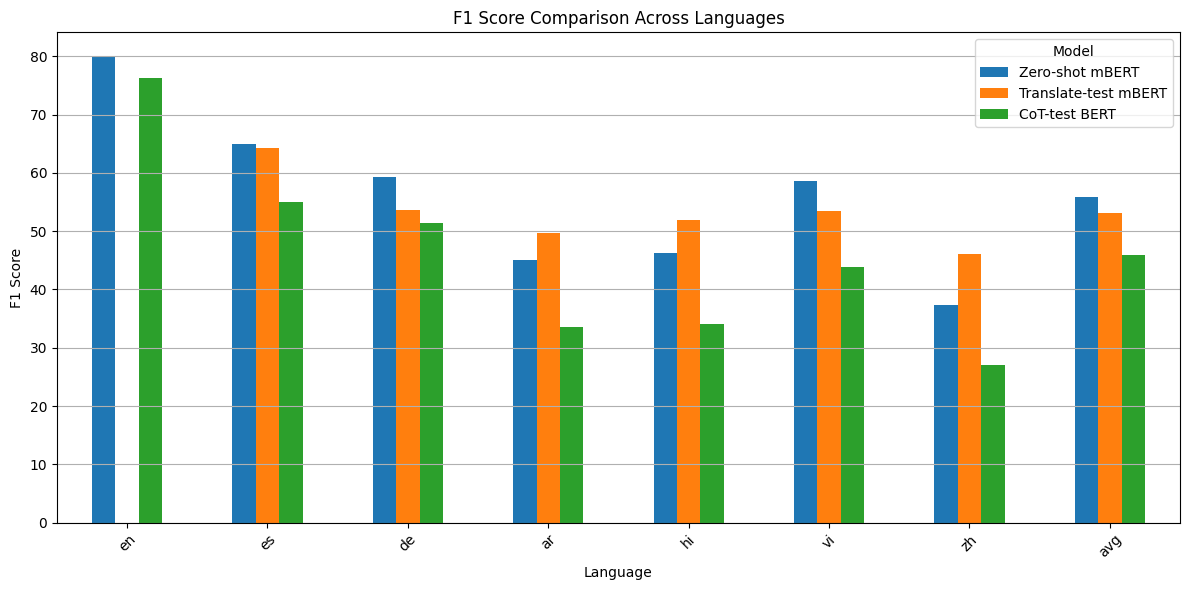

<Figure size 1200x600 with 0 Axes>

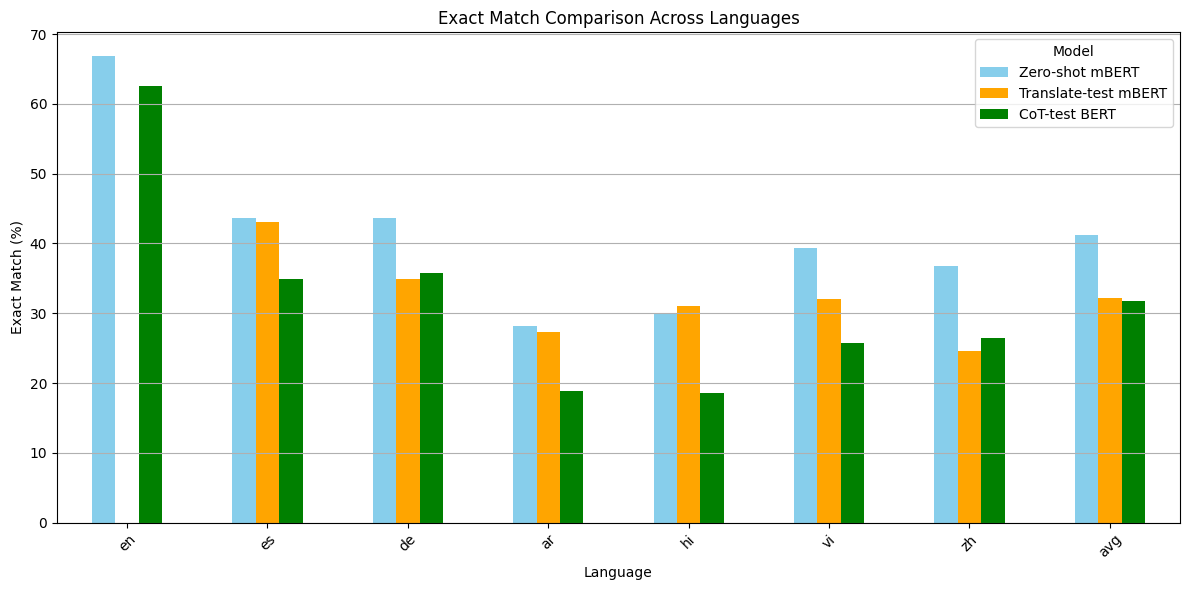

In [149]:
import pandas as pd
import matplotlib.pyplot as plt


# Split the data into F1 and Exact Match DataFrames
df_f1 = df.applymap(lambda x: float(x.split("/")[0]) if isinstance(x, str) else None)  
df_em = df.applymap(lambda x: float(x.split("/")[1]) if isinstance(x, str) else None)  

# Plot 1: F1 Scores
plt.figure(figsize=(12, 6))
df_f1.T.plot(kind="bar", figsize=(12, 6))
plt.title("F1 Score Comparison Across Languages")
plt.xlabel("Language")
plt.ylabel("F1 Score")
plt.xticks(rotation=45)
plt.legend(title="Model", loc="upper right")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

# Plot 2: Exact Match Scores
plt.figure(figsize=(12, 6))
df_em.T.plot(kind="bar", figsize=(12, 6), color=["skyblue", "orange", "green"])
plt.title("Exact Match Comparison Across Languages")
plt.xlabel("Language")
plt.ylabel("Exact Match (%)")
plt.xticks(rotation=45)
plt.legend(title="Model", loc="upper right")
plt.grid(axis="y")
plt.tight_layout()
plt.show()


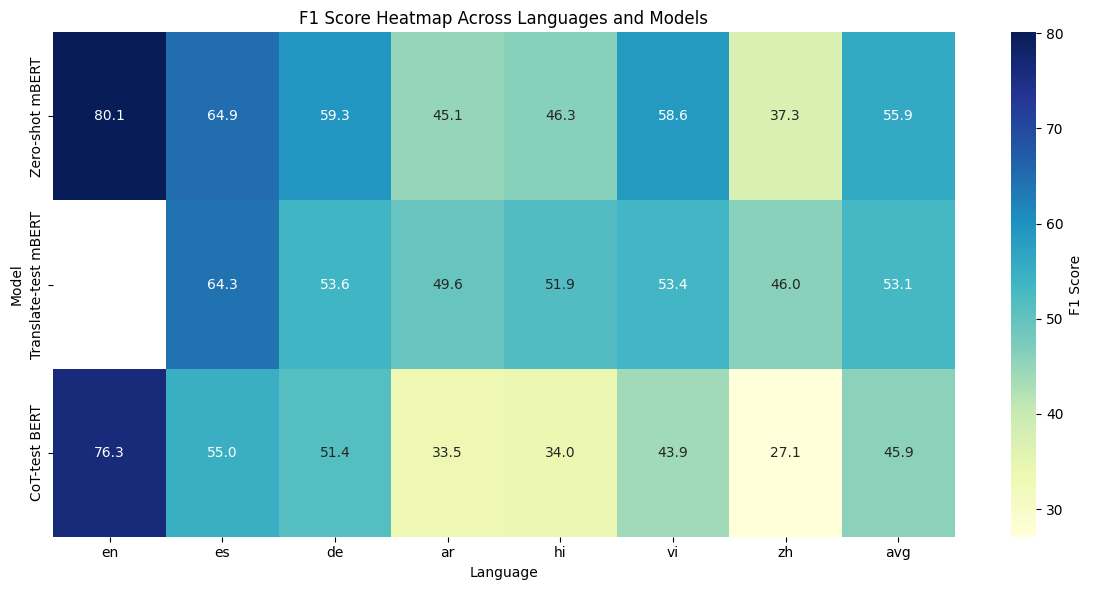

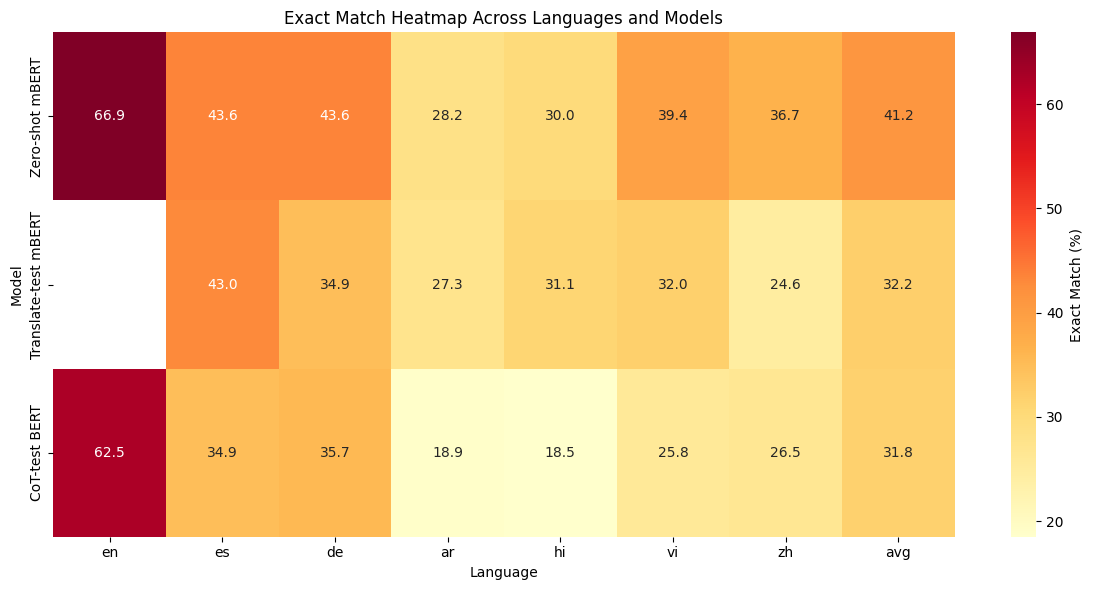

In [155]:
import seaborn as sns

# Plot F1 Scores as a Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df_f1, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'F1 Score'})
plt.title("F1 Score Heatmap Across Languages and Models")
plt.xlabel("Language")
plt.ylabel("Model")
plt.tight_layout()
plt.show()

# Plot Exact Match Scores as a Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df_em, annot=True, fmt=".1f", cmap="YlOrRd", cbar_kws={'label': 'Exact Match (%)'})
plt.title("Exact Match Heatmap Across Languages and Models")
plt.xlabel("Language")
plt.ylabel("Model")
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

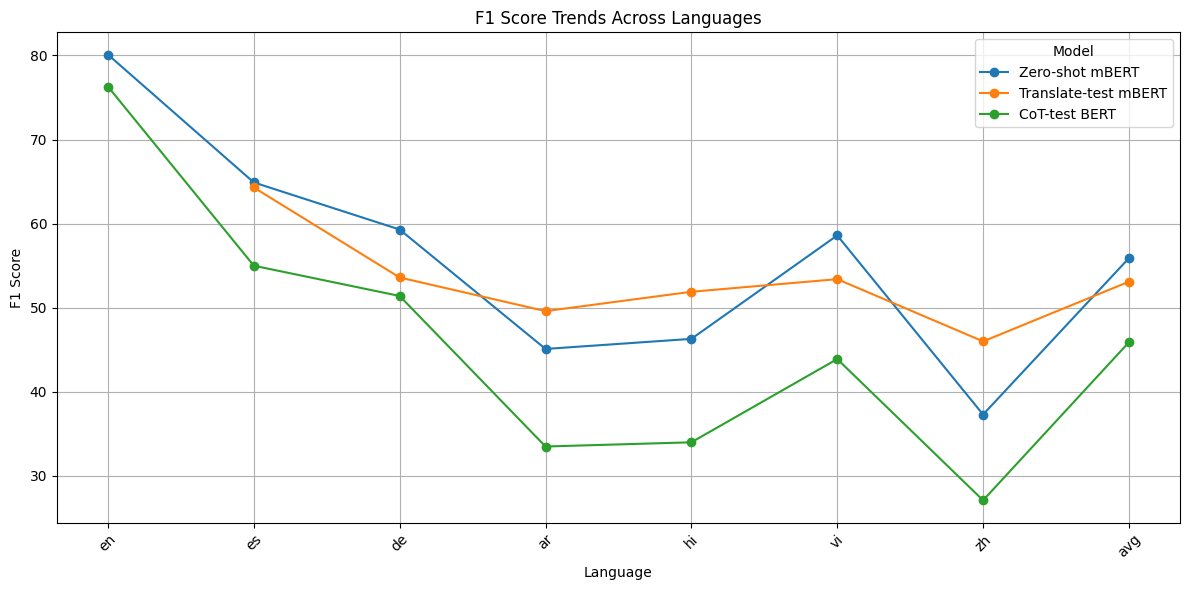

<Figure size 1200x600 with 0 Axes>

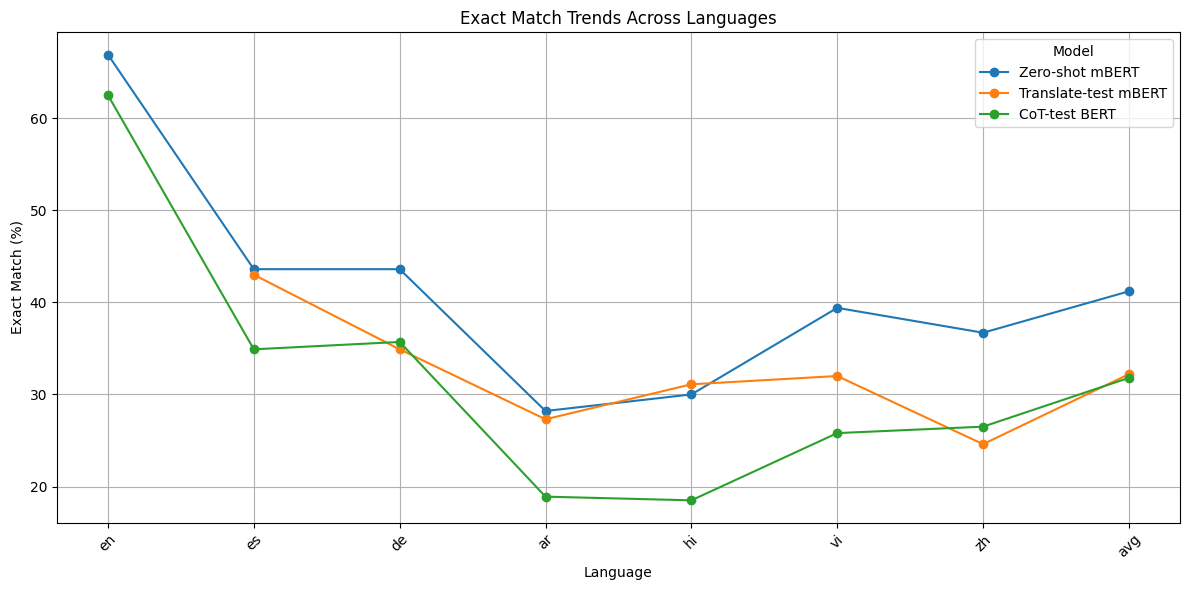

In [156]:
# Plot F1 Scores as Line Chart
plt.figure(figsize=(12, 6))
df_f1.T.plot(kind="line", marker="o", figsize=(12, 6))
plt.title("F1 Score Trends Across Languages")
plt.xlabel("Language")
plt.ylabel("F1 Score")
plt.xticks(rotation=45)
plt.legend(title="Model", loc="upper right")
plt.grid()
plt.tight_layout()
plt.show()

# Plot Exact Match Scores as Line Chart
plt.figure(figsize=(12, 6))
df_em.T.plot(kind="line", marker="o", figsize=(12, 6))
plt.title("Exact Match Trends Across Languages")
plt.xlabel("Language")
plt.ylabel("Exact Match (%)")
plt.xticks(rotation=45)
plt.legend(title="Model", loc="upper right")
plt.grid()
plt.tight_layout()
plt.show()
